In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from ta.trend import EMAIndicator, MACD
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import BollingerBands
from vnstock import Vnstock

# --- Bước 1: Lấy dữ liệu cổ phiếu ---
stock = Vnstock().stock(symbol='VCI', source='VCI')
data = stock.quote.history(start='2018-01-01', end='2025-03-31')

if data.empty:
    raise ValueError("Không lấy được dữ liệu từ vnstock. Kiểm tra symbol hoặc khoảng thời gian.")

data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
print(data)

             open   high    low  close   volume
time                                           
2018-01-02  13.37  14.06  13.37  13.82    68220
2018-01-03  14.23  14.26  13.88  14.23    90850
2018-01-04  14.23  14.57  14.23  14.55    89260
2018-01-05  14.40  14.40  14.23  14.26    18410
2018-01-08  14.24  14.57  14.06  14.48    70280
...           ...    ...    ...    ...      ...
2025-03-25  39.55  39.75  38.85  39.05  6651000
2025-03-26  38.95  39.10  38.30  38.40  7675700
2025-03-27  38.05  38.75  38.05  38.30  7127800
2025-03-28  38.45  38.65  37.55  38.10  9316800
2025-03-31  37.80  38.45  37.80  38.30  7304800

[1808 rows x 5 columns]


In [3]:
ema_indicator = EMAIndicator(close=data['close'], window=10)
data['ema_10'] = ema_indicator.ema_indicator()

rsi_indicator = RSIIndicator(close=data['close'], window=14)
data['rsi_14'] = rsi_indicator.rsi()

macd_indicator = MACD(close=data['close'])
data['macd'] = macd_indicator.macd()


In [7]:
# --- Bước 3: Chọn và chuẩn bị đặc trưng ---
features = ['close', 'volume', 'ema_10', 'rsi_14', 'macd']
data = data[features]
data.dropna(inplace=True)

print("Số lượng mẫu sau khi bỏ NaN:", len(data))
print("Dữ liệu gốc (5 dòng đầu tiên):")
print(data.head())

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

Số lượng mẫu sau khi bỏ NaN: 1783
Dữ liệu gốc (5 dòng đầu tiên):
            close  volume     ema_10     rsi_14      macd
time                                                     
2018-02-06  13.11  272110  14.403347  33.920304  0.098988
2018-02-07  13.71  257290  14.277284  43.092634  0.035461
2018-02-08  13.71   47560  14.174142  43.092634 -0.014715
2018-02-09  13.71  117500  14.089752  43.092634 -0.053859
2018-02-12  13.71  142090  14.020706  43.092634 -0.083914


In [9]:
# --- Bước 4: Tạo dữ liệu chuỗi cho LSTM ---
X = []
y = []
sequence_length = 60 

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, 3])  # Cột 3 là 'close'

X, y = np.array(X), np.array(y)

In [11]:
# --- Bước 5: Chia train/test ---
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

print("Số lượng mẫu trong tập train:", len(X_train))
print("Số lượng mẫu trong tập test:", len(X_test))


Số lượng mẫu trong tập train: 1378
Số lượng mẫu trong tập test: 345


In [13]:
# --- Bước 6: Xây dựng mô hình LSTM cải tiến ---
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# Tối ưu hóa với learning rate scheduler
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler], verbose=1)

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - loss: 0.0613 - val_loss: 0.0111 - learning_rate: 5.0000e-04
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.0193 - val_loss: 0.0116 - learning_rate: 5.0000e-04
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.0162 - val_loss: 0.0087 - learning_rate: 5.0000e-04
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 0.0135 - val_loss: 0.0077 - learning_rate: 5.0000e-04
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0144 - val_loss: 0.0062 - learning_rate: 5.0000e-04
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.0114 - val_loss: 0.0064 - learning_rate: 5.0000e-04
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0103 - val_loss: 0.0062 - learning_rate: 5.0000e-04
Epoch 8/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - loss: 0.0098 - val_loss: 0.0065 - learning_rate: 5.0000e-04
Epoch 9/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 0.0098 - val_loss

In [15]:
# --- Bước 7: Dự đoán và đánh giá ---
predictions = model.predict(X_test)

# Giải mã giá từ dữ liệu scaled
X_test_last = X_test[:, -1, :]
n_samples = X_test_last.shape[0]
n_features = X_test_last.shape[1]  # 13 cột

# Tái tạo mảng dự đoán với đầy đủ 13 cột
X_test_pred_full = np.zeros((n_samples, n_features))
for i in range(n_features):
    if i == 3:  # Cột close
        X_test_pred_full[:, i] = predictions.flatten()
    else:
        X_test_pred_full[:, i] = X_test_last[:, i]
predicted_close = scaler.inverse_transform(X_test_pred_full)[:, 3]

# Tái tạo mảng thực tế với đầy đủ 13 cột
X_test_actual_full = np.zeros((n_samples, n_features))
for i in range(n_features):
    if i == 3:  # Cột close
        X_test_actual_full[:, i] = y_test
    else:
        X_test_actual_full[:, i] = X_test_last[:, i]
actual_close = scaler.inverse_transform(X_test_actual_full)[:, 3]

# Kiểm tra giá trị sau giải mã
print("Mẫu dữ liệu actual_close sau giải mã:", actual_close[:5])
print("Mẫu dữ liệu predicted_close sau giải mã:", predicted_close[:5])

# Tính toán các chỉ số đánh giá
rmse = np.sqrt(mean_squared_error(actual_close, predicted_close))
mae = mean_absolute_error(actual_close, predicted_close)
r2 = r2_score(actual_close, predicted_close)

print("\nKết quả đánh giá mô hình LSTM (đã sửa):")
print(f"- RMSE: {rmse:.2f} VND")
print(f"- MAE: {mae:.2f} VND")
print(f"- R2 Score: {r2:.4f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
Mẫu dữ liệu actual_close sau giải mã: [55.41103861 53.44746471 55.1587156  55.1587156  56.53010267]
Mẫu dữ liệu predicted_close sau giải mã: [55.68485098 56.11832082 54.25737144 54.86002449 55.07419096]

Kết quả đánh giá mô hình LSTM (đã sửa):
- RMSE: 4.40 VND
- MAE: 3.33 VND
- R2 Score: 0.8514


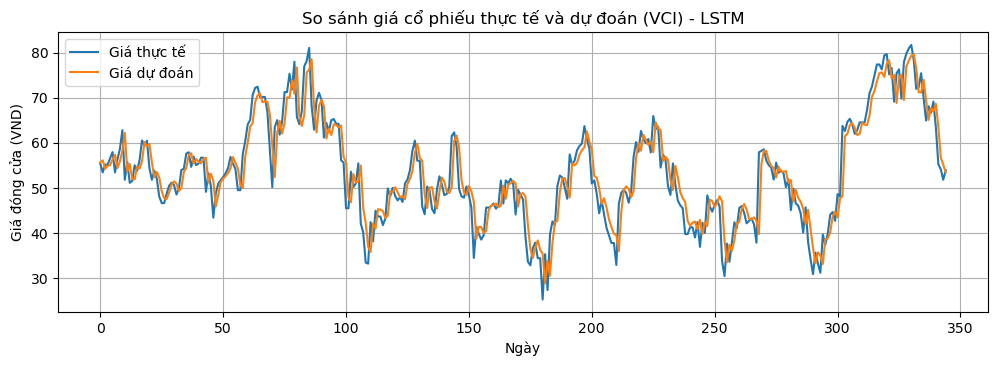

In [17]:
import matplotlib.pyplot as plt
# --- Bước 8: Vẽ biểu đồ so sánh ---
plt.figure(figsize=(12, 8))

# Biểu đồ 1: Giá thực tế và dự đoán
plt.subplot(2, 1, 1)
plt.plot(actual_close, label='Giá thực tế')
plt.plot(predicted_close, label='Giá dự đoán')
plt.title('So sánh giá cổ phiếu thực tế và dự đoán (VCI) - LSTM')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa (VND)')
plt.legend()
plt.grid(True)

In [19]:
percentage_errors = np.abs((actual_close - predicted_close) / actual_close) * 100
mean_percentage_error = np.mean(percentage_errors)
print(f"📉 Sai số tương đối trung bình (MAPE): {mean_percentage_error:.2f}%")

📉 Sai số tương đối trung bình (MAPE): 6.72%


In [21]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s

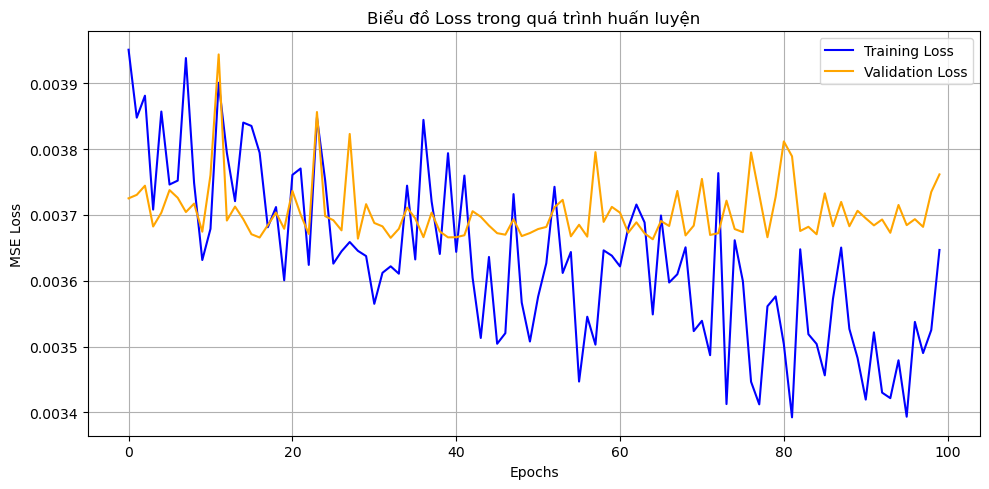

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Biểu đồ Loss trong quá trình huấn luyện')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
# Chuẩn bị dữ liệu đầu vào (60 ngày gần nhất)
last_60_days = data[-60:]
scaled_last_60 = scaler.transform(last_60_days)
input_sequence = list(scaled_last_60)

future_predictions_scaled = []

# Lặp để dự báo 10 ngày tiếp theo
for _ in range(10):
    input_array = np.array(input_sequence[-60:])  # lấy 60 ngày gần nhất
    input_array = input_array.reshape((1, 60, len(features)))
    
    predicted_scaled = model.predict(input_array, verbose=0)
    
    # Tạo vector đầy đủ chiều (vì scaler cần đủ cột)
    last_known = input_sequence[-1].copy()
    full_vector = last_known.copy()
    full_vector[features.index('close')] = predicted_scaled[0][0]
    
    input_sequence.append(full_vector)
    future_predictions_scaled.append(full_vector)

# Giải mã kết quả về giá thực
future_predictions_scaled = np.array(future_predictions_scaled)
future_unscaled = scaler.inverse_transform(future_predictions_scaled)
predicted_close_prices = future_unscaled[:, features.index('close')]

# In kết quả dự báo
import datetime
start_date = data.index[-1] + pd.Timedelta(days=1)
future_dates = pd.date_range(start=start_date, periods=10, freq='B')  # dự báo 10 ngày làm việc

forecast_df = pd.DataFrame({
    'Ngày': future_dates,
    'Dự báo giá đóng cửa (VCI)': predicted_close_prices
})
print(forecast_df)


        Ngày  Dự báo giá đóng cửa (VCI)
0 2025-04-01                  27.736585
1 2025-04-02                  25.981897
2 2025-04-03                  25.328111
3 2025-04-04                  24.589363
4 2025-04-07                  24.024509
5 2025-04-08                  23.620039
6 2025-04-09                  23.339946
7 2025-04-10                  23.155662
8 2025-04-11                  23.042784
9 2025-04-14                  22.982252


X does not have valid feature names, but MinMaxScaler was fitted with feature names
X does not have valid feature names, but MinMaxScaler was fitted with feature names
X does not have valid feature names, but MinMaxScaler was fitted with feature names
X does not have valid feature names, but MinMaxScaler was fitted with feature names
X does not have valid feature names, but MinMaxScaler was fitted with feature names
X does not have valid feature names, but MinMaxScaler was fitted with feature names
X does not have valid feature names, but MinMaxScaler was fitted with feature names
X does not have valid feature names, but MinMaxScaler was fitted with feature names
X does not have valid feature names, but MinMaxScaler was fitted with feature names
X does not have valid feature names, but MinMaxScaler was fitted with feature names


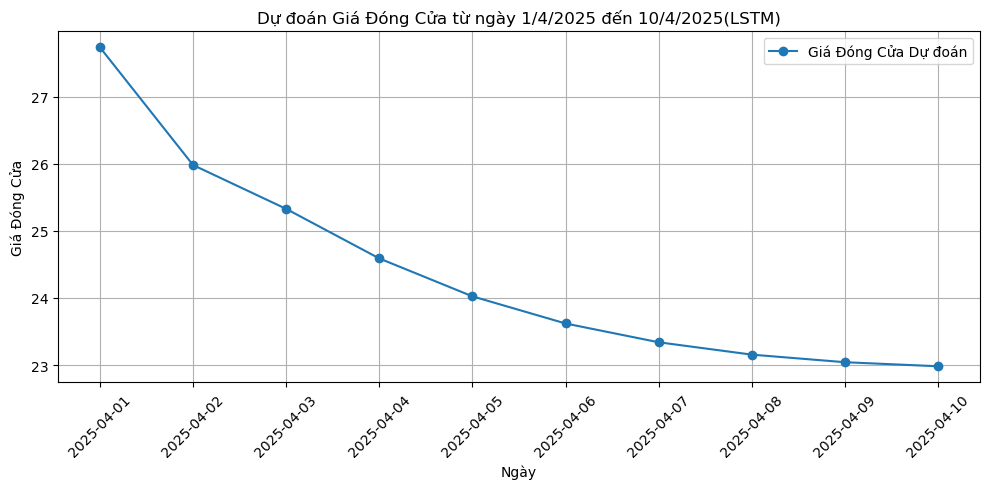

In [85]:
import numpy as np
import pandas as pd
from datetime import timedelta

def predict_price_trend_10_days(model, data, scaler, sequence_length, last_date, n_days=10):
    # Sao chép dữ liệu để không sửa bản gốc
    input_data = data.copy()
    predictions = []
    trend_signals = []
    
    # Lấy chuỗi đặc trưng cuối cùng
    current_sequence = input_data[-sequence_length:].values
    
    for i in range(n_days):
        # Chuẩn hóa chuỗi đầu vào
        scaled_sequence = scaler.transform(current_sequence)
        scaled_sequence = np.array([scaled_sequence])
        
        # Dự đoán giá đóng cửa chuẩn hóa
        predicted_scaled_price = model.predict(scaled_sequence, verbose=0)[0][0]
        
        # Nghịch đảo chuẩn hóa để lấy giá thực
        dummy_array = np.zeros((1, input_data.shape[1]))
        dummy_array[0, 0] = predicted_scaled_price  # Cột 0 là 'close'
        predicted_price = scaler.inverse_transform(dummy_array)[0, 0]
        
        # Ngày dự đoán
        pred_date = last_date + timedelta(days=i + 1)
        
        # Xác định xu hướng dựa trên giá
        if i > 0:
            prev_price = predictions[-1][1]
            if predicted_price > prev_price * 1.005:  # Tăng >0.5%
                trend = "Tăng"
            elif predicted_price < prev_price * 0.995:  # Giảm >0.5%
                trend = "Giảm"
            else:
                trend = "Đi ngang"
        else:
            # Ngày đầu tiên so sánh với giá hiện tại
            current_price = input_data['close'].iloc[-1]
            if predicted_price > current_price * 1.005:
                trend = "Tăng"
            elif predicted_price < current_price * 0.995:
                trend = "Giảm"
            else:
                trend = "Đi ngang"
        
        predictions.append((pred_date, predicted_price))
        trend_signals.append((pred_date, trend))
        
        # Cập nhật chuỗi đầu vào với giá dự đoán
        new_row = current_sequence[-1].copy()  # Sao chép hàng cuối
        new_row[0] = predicted_price  # Cập nhật giá đóng cửa
        
        # Giữ các đặc trưng khác (volume, ema_10, rsi_14, macd) như giá trị cuối
        current_sequence = np.vstack((current_sequence[1:], new_row))
    
    # Tạo DataFrame kết quả
    result_df = pd.DataFrame(predictions, columns=['Date', 'Predicted_Close'])
    result_df['Trend'] = [t[1] for t in trend_signals]
    result_df.set_index('Date', inplace=True)
    
    return result_df

# Sử dụng hàm để dự đoán 10 ngày tiếp theo
last_date = data.index[-1]
price_trend_predictions = predict_price_trend_10_days(
    model, data, scaler, sequence_length=60, last_date=last_date, n_days=10
)
# Vẽ biểu đồ giá dự đoán
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(price_trend_predictions.index, price_trend_predictions['Predicted_Close'], marker='o', label='Giá Đóng Cửa Dự đoán')
plt.title('Dự đoán Giá Đóng Cửa từ ngày 1/4/2025 đến 10/4/2025(LSTM)')
plt.xlabel('Ngày')
plt.ylabel('Giá Đóng Cửa')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()